In [1]:
!rm -r ./reduce-mode-collapse-in-gan
!git clone https://github.com/ThViviani/reduce-mode-collapse-in-gan.git

import sys; sys.path.append('./reduce-mode-collapse-in-gan')

rm: cannot remove './reduce-mode-collapse-in-gan': No such file or directory


Cloning into 'reduce-mode-collapse-in-gan'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 178 (delta 104), reused 123 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (178/178), 2.16 MiB | 21.52 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [2]:
!pip install -r ./reduce-mode-collapse-in-gan/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.5 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [3]:
!rm -r ./gan
!git clone https://github.com/tntrung/gan.git

sys.path.append('./gan')

rm: cannot remove './gan': No such file or directory
Cloning into 'gan'...
remote: Enumerating objects: 508, done.
remote: Total 508 (delta 0), reused 0 (delta 0), pack-reused 508 (from 1)
Receiving objects: 100% (508/508), 2.44 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (300/300), done.


# Prepare 2D data from dist-gan
https://github.com/tntrung/gan/tree/master/distgan_toy2d  
I have problems when i try import the distgan_toy2d module, so i copied some code in this cells.

In [4]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init

In [5]:
VAR = 0.1
BATCH_SIZE = 128
MAX_EPOCHS = 500
SEED = 42

In [6]:
def read_toydata(toyfile):
    fid = open(toyfile,'r')
    lines = fid.readlines()
    data = []
    for line in lines:
        line = line.replace('[', '')
        line = line.replace(']', '')
        data.append([float(curr_num) for curr_num in line.split()])
    fid.close()
    return np.array(data)

In [7]:
def maxabs(a, axis=None):
    amax = a.max(axis)
    amin = a.min(axis)
    return np.where(-amin > amax, amin, amax)

def normalize_toydata(toydata, centroids, var):
    centroids = (centroids/maxabs(np.float32(toydata))+1)/2
    var = (var/maxabs(toydata))/np.sqrt(2)
    toydata = (toydata/maxabs(toydata)+1)/2
    toydata_size = len(toydata)
    return toydata, centroids, var 

In [8]:
grid_centroids = np.array([np.array([i, j]) for i, j in itertools.product(range(-4, 5, 2),
                                                                    range(-4, 5, 2))])
toydata = read_toydata('gan/distgan_toy2d/toy_data/toydatav2.txt')
toydata, grid_centroids, VAR = normalize_toydata(toydata, grid_centroids, VAR)

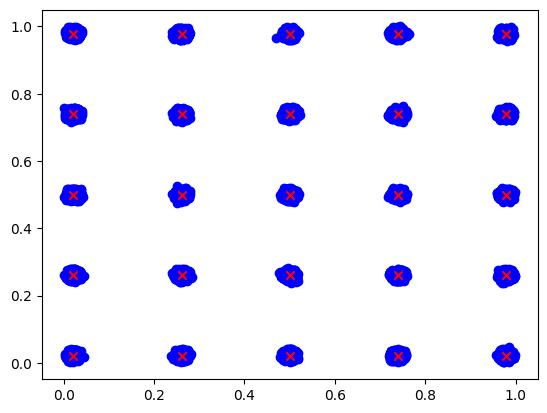

In [9]:
plt.scatter(toydata[:,0], toydata[:,1], color='b')
plt.scatter(grid_centroids[:,0], grid_centroids[:,1], marker='x', color='r')

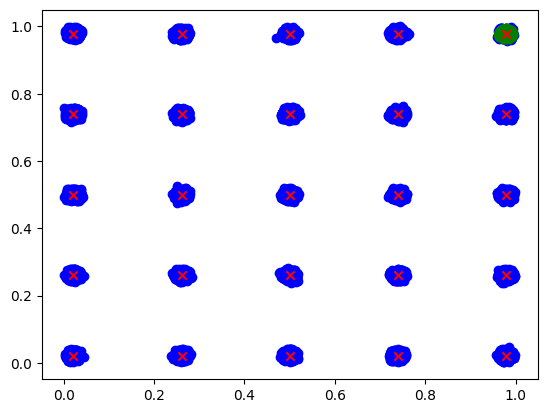

In [10]:
upper_right_corner_mode = toydata[(np.linalg.norm(toydata - grid_centroids[-1], axis=1) <= VAR)]

plt.scatter(toydata[:,0], toydata[:,1], color='b')
plt.scatter(upper_right_corner_mode[:,0], upper_right_corner_mode[:,1], color='g')
plt.scatter(grid_centroids[:,0], grid_centroids[:,1], marker='x', color='r')

In [11]:
def evaluate_mode_covered(data, centroids, var):
    mode_covered = [0 for _ in range(len(centroids))]
    for i in range(len(centroids)):
        subdata = data - centroids[i]
        distance = np.linalg.norm(subdata,axis=1)
        point_in_mode = (distance<=var).sum()
        mode_covered[i] = point_in_mode
    return np.array(mode_covered)

In [12]:
evaluate_mode_covered(toydata, grid_centroids, VAR).sum()

49035

# Networks

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        init.xavier_normal_(self.fc1.weight, gain=init.calculate_gain('relu'))
        init.xavier_normal_(self.fc2.weight, gain=init.calculate_gain('relu'))
        init.xavier_normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Generator2D(MLP):
    def forward(self, x):
        return torch.sigmoid(super().forward(x))

In [14]:
from trainers.adversarial_trainer import AdversarialTraining


class SynteticAdversarialTraining(AdversarialTraining):
    pass

In [13]:
gen = Generator2D()
test_batch = torch.Tensor(toydata[:BATCH_SIZE])
gen(test_batch).min(), gen(test_batch).max()

(tensor(0.4154, grad_fn=<MinBackward1>),
 tensor(0.6144, grad_fn=<MaxBackward1>))